In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import collections

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy.stats as stats

In [2]:
# R code 7.1
d = pd.read_csv('./rethinking/data/rugged.csv', sep=';')

# log gdp
d['log_gdp'] = np.log(d['rgdppc_2000'])

# drop NAs in rgdppc_2000
d.dropna(subset=['rgdppc_2000'], inplace=True)

# sort by rugged, this helps later on
d.sort_values(by='rugged', inplace=True)

d_A1 = d[d.cont_africa == 1]
d_A0 = d[d.cont_africa == 0]

In [12]:
with pm.Model() as m7_1: 
    
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    mu = a + bR * d_A1['rugged']
    
    log_gdp_A1 = pm.Normal('loggdp_A1', mu = mu, sd = sigma, observed=d_A1['log_gdp'])
        
    map_estimate_A1 = pm.find_MAP(model=m7_1)
    _trace_A1 = pm.sample(1000, start=map_estimate_A1)
    
with pm.Model() as m7_2: 
    
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    mu = a + bR * d_A0['rugged']
    
    log_gdp_A0 = pm.Normal('loggdp_A1', mu = mu, sd = sigma, observed=d_A0['log_gdp'])
        
    map_estimate_A0 = pm.find_MAP(model=m7_1)
    _trace_A0 = pm.sample(1000, start=map_estimate_A0)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Assigned NUTS to a
Assigned NUTS to bR
Assigned NUTS to sigma_interval_
 [-----------------100%-----------------] 1000 of 1000 complete in 0.8 secApplied interval-transform to sigma and added transformed sigma_interval_ to model.
Assigned NUTS to a
Assigned NUTS to bR
Assigned NUTS to sigma_interval_
 [-----------------100%-----------------] 1000 of 1000 complete in 0.9 sec

In [14]:
trace_A0 = pm.trace_to_dataframe(_trace_A0)
trace_A1 = pm.trace_to_dataframe(_trace_A1)

In [15]:
# Uncertainty about the mean

mean_df_A0 = trace_A0.apply(lambda x: x['a'] + x['bR'] * d_A0.rugged.sort_values(), axis=1)
mean_df_A0.columns = d_A0.rugged.sort_values()

mean_df_A1 = trace_A1.apply(lambda x: x['a'] + x['bR'] * d_A1.rugged.sort_values(), axis=1)
mean_df_A1.columns = d_A1.rugged.sort_values()

mean_hpd_A0 = pd.DataFrame([pm.hpd(mean_df_A0.iloc[:, i], alpha=.11) for i in range(len(mean_df_A0.columns))], columns=['lower', 'upper'])
mean_hpd_A1 = pd.DataFrame([pm.hpd(mean_df_A1.iloc[:, i], alpha=.11) for i in range(len(mean_df_A1.columns))], columns=['lower', 'upper'])                           

In [16]:
accum_list = []
for rugged_value in d_A0.rugged.sort_values():
    
    sampled_mus = trace_A0.apply(lambda x: x['a'] + x['bR'] * rugged_value, axis=1)
    sampled_sigmas = trace_A0['sigma']
    
    # sample from the Gaussian with mu/sigma
    variates = stats.norm.rvs(loc=sampled_mus, scale=sampled_sigmas)    
    
    # store them
    accum_list.append(variates)
    
accum_df_A0 = pd.DataFrame(accum_list, index=d_A0.rugged.sort_values())

#
# Same thing for A1
#

accum_list = []
for rugged_value in d_A1.rugged.sort_values():
    
    sampled_mus = trace_A1.apply(lambda x: x['a'] + x['bR'] * rugged_value, axis=1)
    sampled_sigmas = trace_A1['sigma']
    
    # sample from the Gaussian with mu/sigma
    variates = stats.norm.rvs(loc=sampled_mus, scale=sampled_sigmas)    
    
    # store them
    accum_list.append(variates)

accum_df_A1 = pd.DataFrame(accum_list, index=d_A1.rugged.sort_values())

#
# Get the posterior predictive 95% interval
#

post_pred_A0 = pd.DataFrame([pm.hpd(accum_df_A0.iloc[i, :], alpha=.11) for i in range(len(accum_df_A0))], columns=['lower', 'upper'], index=accum_df_A0.index)
post_pred_A1 = pd.DataFrame([pm.hpd(accum_df_A1.iloc[i, :], alpha=.11) for i in range(len(accum_df_A1))], columns=['lower', 'upper'], index=accum_df_A1.index)

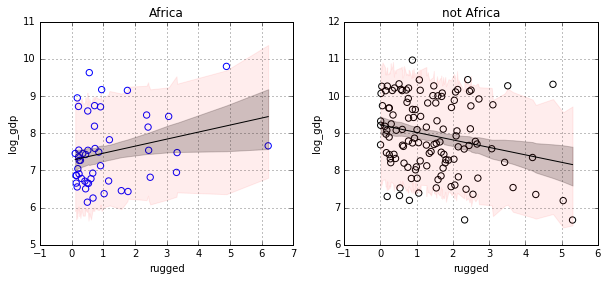

In [17]:
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 4))

ax_left.scatter(d_A1.rugged, d_A1.log_gdp, facecolors='none', edgecolors='b', s=40)
ax_right.scatter(d_A0.rugged, d_A0.log_gdp, facecolors='none', edgecolors='k', s=40)

# mean line
ax_left.plot(d_A1.rugged.sort_values(), mean_df_A1.mean(), c='k')
ax_right.plot(d_A0.rugged.sort_values(), mean_df_A0.mean(), c='k')

# 89% HPD for the mean
ax_left.fill_between(d_A1.rugged.sort_values(), y1=mean_hpd_A1.lower, y2=mean_hpd_A1.upper, alpha=0.2, color='k')
ax_right.fill_between(d_A0.rugged.sort_values(), y1=mean_hpd_A0.lower, y2=mean_hpd_A0.upper, alpha=0.2, color='k')

# 89% HPD for the posterior predictions
ax_left.fill_between(post_pred_A1.index, y1=post_pred_A1.lower, y2=post_pred_A1.upper, alpha=0.07, color='r')
ax_right.fill_between(post_pred_A0.index, y1=post_pred_A0.lower, y2=post_pred_A0.upper, alpha=0.07, color='r')

# labels and titles
ax_left.set_xlabel('rugged'); ax_left.set_ylabel('log_gdp'); ax_left.set_title('Africa');
ax_right.set_xlabel('rugged'); ax_right.set_ylabel('log_gdp'); ax_right.set_title('not Africa');

ax_left.grid();
ax_right.grid();

#### 7.1.2 Adding a linear interaction does work

In [19]:
with pm.Model() as m7_5:
    
    # priors
    a = pm.Normal('a', mu=8, sd=100)
    bA = pm.Normal('bA', mu=0, sd=1)
    bR = pm.Normal('bR', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # linear relationships
    gamma = bR + bAR * d['cont_africa']
    mu = a + gamma * d['rugged'] + bA * d['cont_africa']
    
    log_gdp = pm.Normal('log_gdp', mu = mu, sd = sigma, observed=d['log_gdp'])
        
    map_estimate_m75 = pm.find_MAP(model=m7_5)
    trace_m75 = pm.sample(1000, start=map_estimate_m75)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Assigned NUTS to a
Assigned NUTS to bA
Assigned NUTS to bR
Assigned NUTS to bAR
Assigned NUTS to sigma_interval_
 [-----------------100%-----------------] 1000 of 1000 complete in 1.5 sec

In [20]:
pm.waic(trace_m75, model=m7_5, n_eff=True)

/Users/horatiu/anaconda/lib/python3.5/site-packages/pymc3/stats.py:137: UserWarning: For one or more samples the posterior variance of the 
        log predictive densities exceeds 0.4. This could be indication of 
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


(469.57164262332537, 5.0971049242477298)

In [21]:
trace_m75 = pm.trace_to_dataframe(trace_m75)

In [ ]:
# y = a + bR + bAR * cont_africa * rugged + bA * cont_africa

In [22]:
# # Uncertainty about the mean

mean_df_A1 = trace_m75.apply(
    lambda x: x['a'] + x['bR'] + x['bAR'] * d_A1.rugged * d_A1.cont_africa + x['bA'] * d_A1.cont_africa, axis=1)
mean_df_A1.columns = d_A1.rugged

mean_df_A0 = trace_m75.apply(
    lambda x: x['a'] + x['bR'] + x['bAR'] * d_A0.rugged * d_A0.cont_africa + x['bA'] * d_A0.cont_africa, axis=1)
mean_df_A0.columns = d_A0.rugged

mean_hpd_A0 = pd.DataFrame([pm.hpd(mean_df_A0.iloc[:, i], alpha=.11) for i in range(len(mean_df_A0.columns))], 
                           columns=['lower', 'upper'],
                           index=mean_df_A0.columns)
mean_hpd_A1 = pd.DataFrame([pm.hpd(mean_df_A1.iloc[:, i], alpha=.11) for i in range(len(mean_df_A1.columns))], 
                           columns=['lower', 'upper'],
                           index=mean_df_A1.columns)                           

In [23]:
map_A0 = (map_estimate_m75['a'] 
          + map_estimate_m75['bR'] 
          + map_estimate_m75['bAR'] * d_A0.rugged * d_A0.cont_africa
          + map_estimate_m75['bA'] * d_A0.cont_africa)

map_A1 = (map_estimate_m75['a'] 
          + map_estimate_m75['bR'] 
          + map_estimate_m75['bAR'] * d_A1.rugged * d_A1.cont_africa
          + map_estimate_m75['bA'] * d_A1.cont_africa)     

map_A0.index = d_A0.rugged
map_A1.index = d_A1.rugged

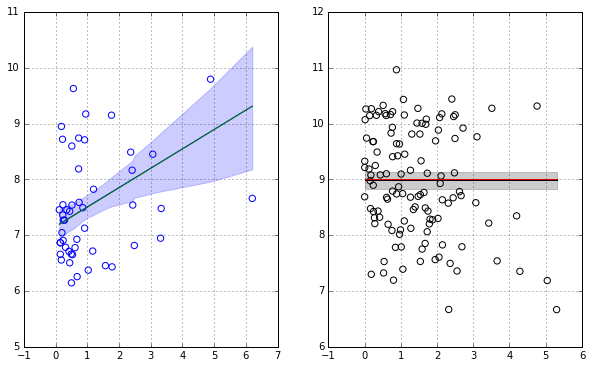

In [26]:
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 6))

ax_left.scatter(d_A1.rugged, d_A1.log_gdp, facecolors='none', edgecolors='b', s=40)
ax_right.scatter(d_A0.rugged, d_A0.log_gdp, facecolors='none', edgecolors='k', s=40)

# # mean lines
ax_left.plot(mean_df_A1.columns, mean_df_A1.mean(), c='b')
ax_right.plot(mean_df_A0.columns, mean_df_A0.mean(), c='k')

# MAP lines
ax_left.plot(map_A1, c='g')
ax_right.plot(map_A0, c='r')

# 89% HPD for the mean
ax_left.fill_between(mean_hpd_A1.index, y1=mean_hpd_A1.lower, y2=mean_hpd_A1.upper, alpha=0.2, color='b')
ax_right.fill_between(mean_hpd_A0.index, y1=mean_hpd_A0.lower, y2=mean_hpd_A0.upper, alpha=0.2, color='k')

# # 89% HPD for the posterior predictions
# ax_left.fill_between(post_pred_A1.index, y1=post_pred_A1.lower, y2=post_pred_A1.upper, alpha=0.07, color='r')
# ax_right.fill_between(post_pred_A0.index, y1=post_pred_A0.lower, y2=post_pred_A0.upper, alpha=0.07, color='r')

# # labels and titles
# ax.set_xlabel('rugged'); ax.set_ylabel('log_gdp');

ax_left.grid(); ax_right.grid();